# Assignment 6

                                "All the work herein is solely mine"
                                
                                
                                                                                                    
                                                          
                                                               Partner: Madhavan Kalkunte Ramachandra (madhkr)

# Problem 1

Implement expectation-maximization algorithm for Gaussian mixture models (see the EM algorithm below) in Python and call this program G<sup>k</sup> . As you present your code explain your protocol for
1. initializing each Gaussian
2. deciding ties
3. stopping criteria

# Solution

In [1]:
pip install sklearn matplotlib pandas numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached scikit-learn-1.0.1.tar.gz (6.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 /usr/lib/python3.10/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /tmp/tmpmm8gxwn8
       cwd: /tmp/pip-install-hwl6k7cc/scikit-learn_093ae211dde3442d90f67cb2996efb47
  Complete output (947 lines):
  Partial import of sklearn during the build process.
  C compiler: gcc -Wno-unused-result -Wsign-compare -DDYNAMIC_ANNOTATIONS_ENABLED=1 -DNDEBUG -O2 -fexceptions -g -grecord-gcc-switches -pipe -Wal

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import sys
import time

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt


def read_ionosphere_text(dataset_name):
    dataframe = pd.read_csv(dataset_name, header=None)
    dataframe[len(dataframe.columns) - 1] = dataframe[len(dataframe.columns) - 1].apply(lambda x: 0 if x == 'b' else 1)
    return dataframe.values


def read_dataset(dataset_name):
    return np.genfromtxt(dataset_name)


def expectation_maximization(dataset_name, num_clusters):
    if dataset_name == 'ionosphere.data':
        data = read_ionosphere_text(dataset_name)
    else:
        data = read_dataset(dataset_name)
    cols = len(data[0])
    data_features = data[:, 0:cols - 1]
    data_classes = data[:, cols - 1:]
    num_features = len(data_features[0])

    # split the data set into training and testing sets. We will do the training on train set.
    x_train, y_train = data_features, data_classes

    cluster_means = []
    cluster_covariance = []
    priors = []
    n = len(x_train)

    start_time = time.perf_counter()

    for k in range(num_clusters):
        mean = []
        # random initialization of mean
        random_x = x_train[random.randint(0, n) - 1]
        for i in range(len(random_x)):
            mean.append(random_x[i])

        cluster_means.append(np.asarray(mean))

        # initialize covariance with identity matrix
        cluster_covariance.append(np.identity(num_features))

        # initial prior probability with uniform probability
        priors.append(1.0 / num_clusters)

    # initialize weights with zero
    w = np.zeros((num_clusters, n))
    iterations = 0

    # Repeat until convergence
    while True:
        # print("running iteration: ", iterations)
        iterations += 1
        # calculate the initial weights assigned to each feature. This loop calculates likelihood * prior
        for k in range(num_clusters):
            for j in range(n):
                w[k][j] = multivariate_normal.pdf(x_train[j], mean=cluster_means[k], cov=cluster_covariance[k],
                                                  allow_singular=True) * priors[k]
        # calculates the denominators i.e P(datapoint) for each datapoint and updates the weight
        calculated_sum = []
        for j in range(n):
            s = 0
            for k in range(num_clusters):
                s += w[k][j]
            calculated_sum.append(s)
            for k in range(num_clusters):
                w[k][j] = w[k][j] / s
        new_means = []
        new_covariance = []
        # for each cluster, recalculate the mean and covariance
        for k in range(num_clusters):
            new_mean = (1 / np.sum(w[k])) * np.matmul(w[k], x_train)
            new_covar = np.zeros((num_features, num_features))
            weight_sum = np.sum(w[k]).item()
            if weight_sum == 0:
                print(weight_sum)
            for j in range(n):
                feature_minus_mean = np.subtract(data_features[j], new_mean)[np.newaxis]
                a = w[k][j]
                sum_term = a * np.matmul(feature_minus_mean.T, feature_minus_mean)
                new_covar = np.add(new_covar, sum_term)
            new_covar = (1 / weight_sum) * new_covar
            new_covar[np.diag_indices_from(new_covar)] += 0.00001
            new_means.append(new_mean)
            new_covariance.append(new_covar)
            priors[k] = weight_sum / len(data_features)

        # check if the difference between new mean calculated and existing mean if small enough to consider convergence.
        diff = 0
        for k in range(num_clusters):
            diff += np.linalg.norm(np.subtract(cluster_means[k], new_means[k])) ** 2
        # check for convergence
        if diff <= 0.0001:
            break

        # update the mean and covariance
        cluster_means = new_means
        cluster_covariance = new_covariance

    # calculate the mean of two classes of training set.
    good_cluster, bad_cluster = [], []
    for j in range(n):
        if int(y_train[j].item()) == 0:
            bad_cluster.append(x_train[j])
        else:
            good_cluster.append(x_train[j])
    good_cluster_mean = np.mean(np.array(good_cluster), axis=0)
    bad_cluster_mean = np.mean(np.array(bad_cluster), axis=0)

    # decide which k is good cluster and which k is bad cluster in our clusters
    # cluster_mapping = {0: 0, 1: 1}
    cluster_mapping = {}

    def f(x):
        return x ** 2

    vectorized_square = np.vectorize(f)
    
    # calculuate the euclidian distance between actual mean and calculated cluster means to determine which 
    # of our clusters corressponds to which of the actual clusters.
    for k in range(num_clusters):
        g_minus_k = np.subtract(cluster_means[k], good_cluster_mean)
        g_minus_k = vectorized_square(g_minus_k)
        g = np.sqrt(np.sum(g_minus_k).item())
        b_minus_k = np.subtract(cluster_means[k], bad_cluster_mean)
        b_minus_k = vectorized_square(b_minus_k)
        b = np.sqrt(np.sum(b_minus_k).item())
        if g < b:
            cluster_mapping[k] = 1
        else:
            cluster_mapping[k] = 0
            
    # make hard assignments and calculate the error rate
    errors = 0
    for j in range(len(x_train)):
        prob = -sys.maxsize
        prob_sum = 0
        for k in range(num_clusters):
            prob_sum += w[k][j]
            if w[k][j] > prob:
                prob = w[k][j]
                assigned_cluster = cluster_mapping[k]
        actual_cluster = y_train[j].item()
        if int(assigned_cluster) != int(actual_cluster):
            errors += 1
    end_time = time.perf_counter()

    return {'error': errors / len(x_train), 'iterations': iterations, 'runtime': end_time - start_time}


# Approach

## Initializing each gaussian

### Mean initialization
A random number **r** is chosen in the range [0, n) where n is the number of datapoints. The datapoint present at the index represented by random number **r** is initialzed as the mean for a cluster.

The above method is repeated for each gaussian (one for each cluster we consider).

### Covariance initialization

For each cluster, the covariance is by default initialized with identity matrix.

### Prior initialization

For each cluster, the prior probaility is assigned with uniform probability i.e 1/k where k is the number of clusters.

```
for k in range(num_clusters):
        mean = []
        # random initialization of mean
        random_x = x_train[random.randint(0, n) - 1]
        for i in range(len(random_x)):
            mean.append(random_x[i])

        cluster_means.append(np.asarray(mean))

        # initialize covariance with identity matrix
        cluster_covariance.append(np.identity(num_features))

        # initial prior probability with uniform probability
        priors.append(1.0 / num_clusters)
```

## Deciding Ties

Tie may appear in two situations:
1. **When assigning our cluster to actual cluster** - We calculate the euclidian distance between our cluster mean and actual cluster means and assign nearest actual cluster to our cluster - **The tie may occur when all actual clusters are equidistant from our cluster**. The Tie is resolved by assigning the first actual cluster in order. i.e if our cluster k is nearest to actual clusters 0 and 1, then k is assigned to cluster 0.
2. **When assigning a cluster to datapoint** - occurs when a datapoint has same probability weights assigned for each cluster - The tie is resolved again by assigning the first cluster in order. i.e if there are two clusters 0 and 1, and datapoint x. if x is assigned probability 0.5 for both clusters 0 and 1, then x is assigned to cluster 0.

## Stopping Criteria

The algorithm stops when the cluster means have converged. The definition of convergance is as follows:

Let number of clusters be $k$,  $t$ be the current iteration number. For cluster i, let mean be $\mu_i$ then algorithm is converged when $\Sigma^k \mid \mid \mu_i^t - \mu_i ^ {t-1} \mid \mid ^ 2 < 0.00001 $

# Problem 3.2

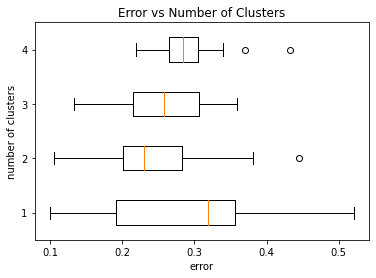

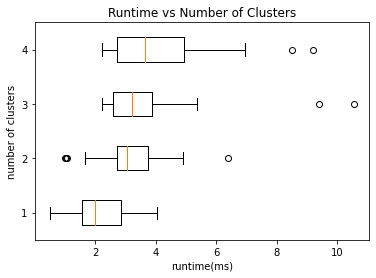

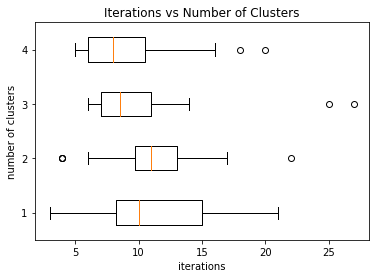

<Figure size 432x288 with 0 Axes>

In [3]:
def run_experiment_ionosphere():
    number_clusters = [2, 3, 4, 5]
    results = {}

    for k in number_clusters:
        runtimes = []
        iterations = []
        errors = []
        for run in range(20):
            cur_result = expectation_maximization('ionosphere.data', k)
            runtimes.append(cur_result['runtime'])
            iterations.append(cur_result['iterations'])
            errors.append(cur_result['error'])
        results[k] = {'runtime': runtimes, 'iterations': iterations, 'error': errors}

    # Plotting whisker plot for error rate for different cluster numbers
    plt.boxplot([ results[x]['error'] for x in number_clusters], vert=0)
    plt.xlabel('error')
    plt.ylabel('number of clusters')
    plt.title('Error vs Number of Clusters')
    plt.show()
    plt.clf()
        
    # Plotting whisker plot for runtime for different cluster numbers
    plt.boxplot([ results[x]['runtime'] for x in number_clusters], vert=0)
    plt.xlabel('runtime(ms)')
    plt.ylabel('number of clusters')
    plt.title('Runtime vs Number of Clusters')
    plt.show()
    plt.clf()
    
    # Plotting whisker plot for iterations for different cluster numbers
    plt.boxplot([ results[x]['iterations'] for x in number_clusters], vert=0)
    plt.xlabel('iterations')
    plt.ylabel('number of clusters')
    plt.title('Iterations vs Number of Clusters')
    plt.show()
    plt.clf()

run_experiment_ionosphere()

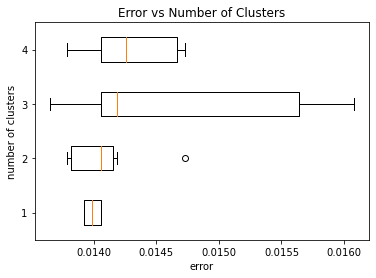

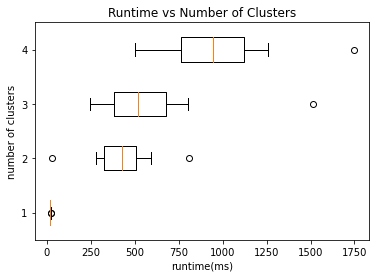

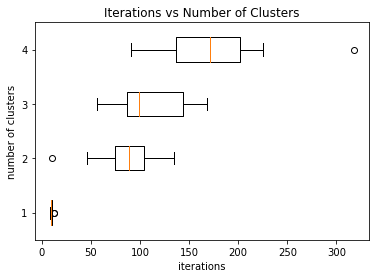

<Figure size 432x288 with 0 Axes>

In [4]:
def run_experiment_ringnorm():
    number_clusters = [2, 3, 4, 5]
    results = {}

    for k in number_clusters:
        runtimes = []
        iterations = []
        errors = []
        for run in range(10):
            cur_result = expectation_maximization('Dataset.data', k)
            runtimes.append(cur_result['runtime'])
            iterations.append(cur_result['iterations'])
            errors.append(cur_result['error'])
        results[k] = {'runtime': runtimes, 'iterations': iterations, 'error': errors}

    # Plotting whisker plot for error rate for different cluster numbers
    plt.boxplot([ results[x]['error'] for x in number_clusters], vert=0)
    plt.xlabel('error')
    plt.ylabel('number of clusters')
    plt.title('Error vs Number of Clusters')
    plt.show()
    plt.clf()
        
    # Plotting whisker plot for runtime for different cluster numbers
    plt.boxplot([ results[x]['runtime'] for x in number_clusters], vert=0)
    plt.xlabel('runtime(ms)')
    plt.ylabel('Number of Clusters')
    plt.title('Runtime vs Number of Clusters')
    plt.show()
    plt.clf()
    
    # Plotting whisker plot for iterations for different cluster numbers
    plt.boxplot([ results[x]['iterations'] for x in number_clusters], vert=0)
    plt.xlabel('iterations')
    plt.ylabel('number of clusters')
    plt.title('Iterations vs Number of Clusters')
    plt.show()
    plt.clf()
    
run_experiment_ringnorm()

# Problem 3.1

Given a text D and a pattern P, describe an Ω(d+p) time method for finding the longest prefix of P that is a substring of D. The lengths of D and P are d and p, respectively.

## Solution:

Using the Trie data structure we can solve the longest prefix of pattern P in a text D in Ω(d+p).

### Algorithm:

* *Input: Text D, Characters in P*
* *Output: Longest Prefix String*

**LongestPrefix(D, P):**
```
1.  construct a TRIE for given text D
2.  let node = root of TRIE representation of text D
3.  longest_prefix = ''
4.  for each character ch in P :
5.      longest_prefix = node.value
6.      if node.reference[ch] != NULL:
7.         node = node.reference[ch]
8.      else:
9.         break - no further match for pattern exists in text
10. return longest_prefix
```

## Run time analysis

A Trie can be implemented in Ω(n * m) where n is the number of words in the text and m is the average length of a word in D. In other words n * m = d (total length of text / total number of characters in D). 
> **Hence creation of Trie can be done in Ω(d)**

**Further the for loop in lines 4 through 9 runs in linear time of length of Pattern p. i.e Ω(p)**

> **Hence the overall complexity of the algorithm = Ω(d) + Ω(p) = Ω(d+p)**



# Problem 3.2

X, Y, and Z are three arrays and each has m elements. For an arbitrary integer t, describe O(m<sup>2</sup> logm)-time algorithm to determine if there exist numbers, x in X, y in Y, and z in Z, such that t = x+y+z.


## Solution:


### Algorithm:

**ArbitarySum(X, Y, Z, t):**
```
1. Sort(Z)
2. for x in X:
3.   for y in Y:
4.      z_wanted = t - x - y
5.      if BinarySearch(Z, z_wanted) == True:
6.         return x, y, z_wanted
7. return -1 (not exists)
```
To get a O(m<sup>2</sup>logm) time complexity, we need to do the following:
* Lets assume each array X,Y,Z is of length m
* We can iterate over any of the two arrays (For ex:X and Y) out of three(X,Y,Z) given above. We can find the z value by subtracting x value from X and y value from Y from t(total value). Since there would be 2 for loops this operation runs in O(m<sup>2</sup>) time.
* We search the z value in Z array using **Binary Search** which runs in logarithmic time. The array must be sorted to apply Binary search so we sort Z.

### Runtime analysis:


1. Sorting of Z takes O(mlogm) time
2. Nested for loops in line 2 and 3 takes O(m<sup>2</sup>) time.
3. Body of nested for loop: Binary search takes O(logm) time
4. Therefore lines 2 through 6 takes m<sup>2</sup>logm time


> **Hence overall worst case time complexity is O(mlogm + m<sup>2</sup>logm) = O(m<sup>2</sup>logm)** 

# Problem 3.3

Describe an efficient algorithm for deleting a string from a compressed trie and analyze its running time.

## Solution:

### Approach:

To delete a string from compressed trie we do the following:
We consider a **NODE** datastructure to represent a trie node. We take the input of the algorithm to be a node, key to delete and depth of key found. We first check if the node is null, if yes we return null.

If the node is not null,we check if the key is complete word in trie i.e if it is a leaf node.If it is a leaf node we delete that node from the trie.

If the node is not a leaf node, then the node representing the word is a prefix to other words: mark the node with isWord to False, indicating  that the word no longer exists in the trie.

We check if the node is Empty using ***isEmpty()*** function which tells whether a node has children or not.

We denote compressed trie using Node data structure which consists of 

1. **value**:represents the value of the node.
2. **child**:references to children nodes
3. **isWord**: boolean flag which denotes whether a node represents the given word
```
class Node:
        value : String
        children : Node[]
        isWord : boolean
```    
### Algorithm: Deleting a key in Compressed trie

**DeleteKey(node, key, depth)**
```
if node == null:
    return null
    
label = node.value
start_index = depth
end_index = depth + label.length

// label is longer than remaining part of key to be matched. Hence there is no match for key.
if end_index > key.length
    return node 

// if part of key does not match with label, then key does not exist in TRIE, just return node
if key[start_index:end_index] != label
    return node

// check if key is completely matched.
if end_index == key.length and node.isWord
    // we have found the word, mark the node as not a word.
    node.isWord = False

    // remove the node if it is empty
    if node is empty
        node = null

    return node

// if we have not completely matched, we continue traversal from end_index recursively

node[end_index] = DeleteKey(node[end_index], key, end_index)

// remove the node if it is empty and does not represent a word
if node is empty and node.isWord = False
    node = null
    
return node

```

_A node is empty if all the children nodes are null._

**isEmpty(node)**
```
for each child in node.children:
    if node.children != null
        return False
return True
```
### Runtime Analysis:

The worst case time complexity for deletion of a key/ word from a compressed trie is O(n) where n is the length of the key/ word to be deleted.

